# 1. Preparación de los datos

## 1.1. Extracción y transformación del archivo base

In [46]:
import pandas as pd

"""
Extracción de datos
"""
path = "./archivos_base/TelecomX_Data.json"
data_json = pd.read_json(path)
df_raw = pd.DataFrame(data_json)

# Normalización
df = pd.json_normalize(df_raw.to_dict(orient="records"))

"""
Corrección y limpieza de datos
"""
df_clean = df.copy()

# Churn: reemplazar valores vacíos y filtrar registros sin valor conocido
df_clean["Churn"] = df_clean["Churn"].replace("", "Unknown")
df_clean = df_clean[df_clean["Churn"].isin(["Yes", "No"])].copy()
# Limpiar espacios en columnas de texto"
for col in df_clean.select_dtypes(include = ["object", "str"]).columns:
    df_clean[col] = df_clean[col].str.strip()
#  TotalCharges a numérico
df_clean["account.Charges.Total"] = pd.to_numeric(
    df_clean["account.Charges.Total"], errors = "coerce"
)
df_clean["account.Charges.Total"] = df_clean["account.Charges.Total"].fillna(df_clean["account.Charges.Total"].median())
# Eliminar duplicados por cliente
df_clean = df_clean.drop_duplicates(subset="customerID")

"""
Modificación de características
"""
# Creación de la columna "Cuentas_Diarias"
df_clean["Cuentas_Diarias"] = (df_clean["account.Charges.Monthly"] / 30).round(4)

"""
Estandarización y transformación
"""
# Conversión binaria de "Churn"
df_clean["Churn_bin"] = df_clean["Churn"].map({"No":0, "Yes":1})
# Codificación binaria de variables Yes/No
binary_cols = [
    "customer.Partner",
    "customer.Dependents",
    "phone.PhoneService",
    "account.PaperlessBilling"
]
for col in binary_cols:
    df_clean[col] = df_clean[col].map({"No":0, "Yes":1})
# Renombrar columnas
df_clean.rename(columns = {
    "account.Charges.Monthly": "Cargos_Mensuales",
    "account.Charges.Total": "Cargos_Totales",
    "account.Contract": "Tipo_Contrato",
    "account.PaymentMethod": "Metodo_Pago"
}, inplace = True)

df_clean.head()


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,Tipo_Contrato,account.PaperlessBilling,Metodo_Pago,Cargos_Mensuales,Cargos_Totales,Cuentas_Diarias,Churn_bin
0,0002-ORFBO,No,Female,0,1,1,9,1,No,DSL,...,Yes,Yes,No,One year,1,Mailed check,65.6,593.30,2.1867,0
1,0003-MKNFE,No,Male,0,0,0,9,1,Yes,DSL,...,No,No,Yes,Month-to-month,0,Mailed check,59.9,542.40,1.9967,0
2,0004-TLHLJ,Yes,Male,0,0,0,4,1,No,Fiber optic,...,No,No,No,Month-to-month,1,Electronic check,73.9,280.85,2.4633,1
3,0011-IGKFF,Yes,Male,1,1,0,13,1,No,Fiber optic,...,No,Yes,Yes,Month-to-month,1,Electronic check,98.0,1237.85,3.2667,1
4,0013-EXCHZ,Yes,Female,1,1,0,3,1,No,Fiber optic,...,Yes,Yes,No,Month-to-month,1,Mailed check,83.9,267.40,2.7967,1


## 1.2. Eliminación de columnas irrelevantes
Se eliminan las columnas que no aportan valor al análisis o a los modelos predictivos, como identificadores únicos (ID del cliente, entre otros).

In [47]:
df_clean = dfdf_clean = df_clean.drop(columns=["customerID"])
df_clean.head()

,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,...,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,Tipo_Contrato,account.PaperlessBilling,Metodo_Pago,Cargos_Mensuales,Cargos_Totales,Cuentas_Diarias,Churn_bin
0,No,Female,0,1,1,9,1,No,DSL,No,...,Yes,Yes,No,One year,1,Mailed check,65.6,593.30,2.1867,0
1,No,Male,0,0,0,9,1,Yes,DSL,No,...,No,No,Yes,Month-to-month,0,Mailed check,59.9,542.40,1.9967,0
2,Yes,Male,0,0,0,4,1,No,Fiber optic,No,...,No,No,No,Month-to-month,1,Electronic check,73.9,280.85,2.4633,1
3,Yes,Male,1,1,0,13,1,No,Fiber optic,No,...,No,Yes,Yes,Month-to-month,1,Electronic check,98.0,1237.85,3.2667,1
4,Yes,Female,1,1,0,3,1,No,Fiber optic,No,...,Yes,Yes,No,Month-to-month,1,Mailed check,83.9,267.40,2.7967,1


## 1.3. Enconding
Transformación de las variables categóricas a formato numérico para hacerlas compatibles con los algoritmos de machine learning.

In [48]:
# Unificación de valores redundantes en columnas de servicions adicionales (Yes/No)
service_cols = [
    "phone.MultipleLines",
    "internet.OnlineSecurity",
    "internet.OnlineBackup",
    "internet.DeviceProtection",
    "internet.TechSupport",
    "internet.StreamingTV",
    "internet.StreamingMovies"
]
for col in service_cols:
    df_clean[col] = df_clean[col].replace({
        "No phone service": "No",
        "No internet service": "No"
    })
    
# Label encoding de "Customer_gender"
df_clean["customer.gender"] = df_clean["customer.gender"].map({
    "Female":0,
    "Male":1    
})

for col in service_cols:
    df_clean[col] = df_clean[col].map({"No":0, "Yes":1})
    
# Ordinal encoding de "Tipo_Contrato"
contract_order = {
    "Month-to-month": 0,
    "One year": 1,
    "Two year": 2
}
df_clean["Tipo_Contrato"] = df_clean["Tipo_Contrato"].map(contract_order)

# One - hot encoding de variabes nominales sin orden
df_clean = pd.get_dummies(
    df_clean, 
    columns = ["internet.InternetService", "Metodo_Pago"],
    drop_first = True,
    dtype = int
)

df_clean.head()

,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.OnlineSecurity,internet.OnlineBackup,...,account.PaperlessBilling,Cargos_Mensuales,Cargos_Totales,Cuentas_Diarias,Churn_bin,internet.InternetService_Fiber optic,internet.InternetService_No,Metodo_Pago_Credit card (automatic),Metodo_Pago_Electronic check,Metodo_Pago_Mailed check
0,No,0,0,1,1,9,1,0,0,1,...,1,65.6,593.30,2.1867,0,0,0,0,0,1
1,No,1,0,0,0,9,1,1,0,0,...,0,59.9,542.40,1.9967,0,0,0,0,0,1
2,Yes,1,0,0,0,4,1,0,0,0,...,1,73.9,280.85,2.4633,1,1,0,0,1,0
3,Yes,1,1,1,0,13,1,0,0,1,...,1,98.0,1237.85,3.2667,1,1,0,0,1,0
4,Yes,0,1,1,0,3,1,0,0,0,...,1,83.9,267.40,2.7967,1,1,0,0,0,1


## 1.4. Verificación de la proporción de cancelación (churn)
Cálculo de la proporción de clientes que cancelaron en relación con los que permanecieron activos. Se evalúa si existe un desbalance entre las clases, ya que esto puede impactar en los modelos predictivos y en el análisis de los resultados. 

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Cálculo de proporciones
churn_counts = df_clean["Churn"].value_counts()
churn_props = df_clean["Churn"].value_counts(normalize = True) * 100

churn_summary = pd.DataFrame({
    "Cantidad": churn_counts,
    "Porcentaje (%)": churn_props.round(2)
})

print("=== Proporción de Churn ===")
print(churn_summary)
print(f"Ratio de desbalance: {(churn_counts.max() / churn_counts.min()).round(2)}")

=== Proporción de Churn ===
       Cantidad  Porcentaje (%)
Churn                          
No         5174           73.46
Yes        1869           26.54
Ratio de desbalance: 2.77


Se observa que existe un desbalance leve, en el que la cantidad de clientes que no cancelan son 2.77 veces la cantidad de clientes que si cancelan (aprox 1 de cada 4 clientes abandona el servicio). Se recomienda monitorear métricas como F1-score.

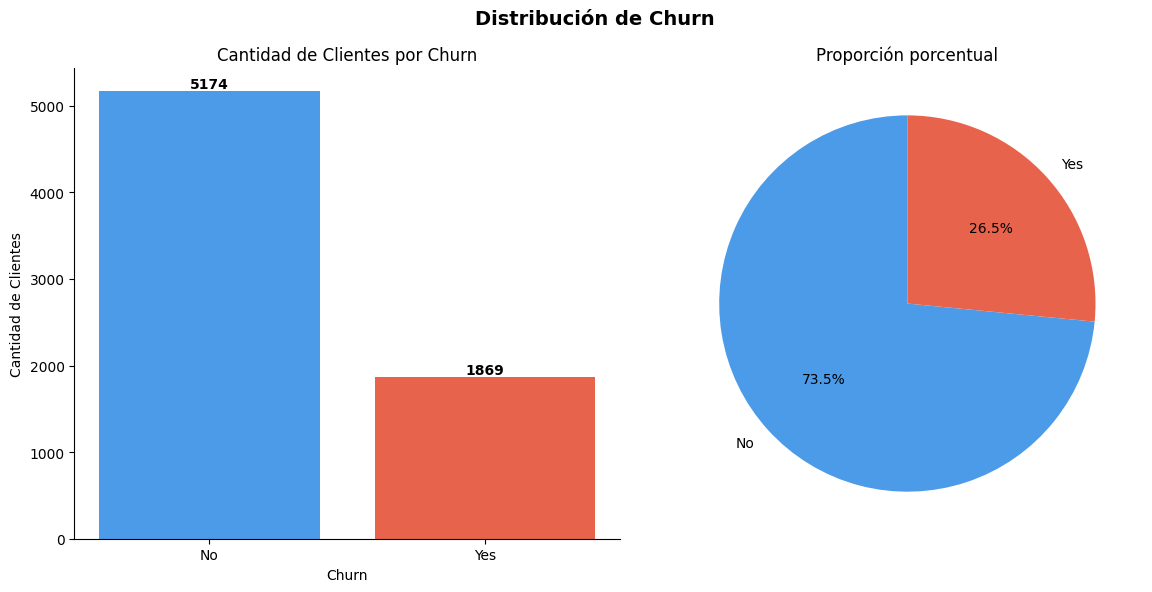

In [50]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
fig.suptitle("Distribución de Churn", fontsize = 14, fontweight = "bold")
colors = ["#4C9BE8", "#E8634C"]

# Gráfico de barras
axs[0].bar(churn_counts.index, churn_counts.values, color = colors)
axs[0].set_title("Cantidad de Clientes por Churn")
axs[0].set_xlabel("Churn")
axs[0].set_ylabel("Cantidad de Clientes")

for i, (label, val) in enumerate(churn_counts.items()):
    axs[0].text(i,val + 30, str(val), ha = "center", fontweight = "bold")
    
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)

# Gráfico circular
axs[1].pie(
    churn_props.values,
    labels=churn_props.index,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90
)
axs[1].set_title("Proporción porcentual")

plt.tight_layout()
plt.show()

En los gráficos también se oberva que los clientes que no cancelan ("No") conforman una proporción altamente superior respecto a los que cancelan ("Yes"). Es decir, existe un desbalance y la clase minoritaria ("Yes") tiene poca representación, pero significativa, como para que los modelos puedan aprender de ellas sin técnicas agresivas de balanceo. 

## 1.5. Normalización o estandarización
Ya que se usará un modelo de regresión logística, se realizará un proceso de normalización o estandarización de los datos. Sumado a estos, se usarán modelos de Random Forest, Decision Tree y XGBoost, que no requieren este pre-procesamiento. 

# 2. Correlación y selección de variables

## 2.1. Análisis de correlación
Se visualiza la matriz de correlación para identificar relaciones entre las variables numéricas. 

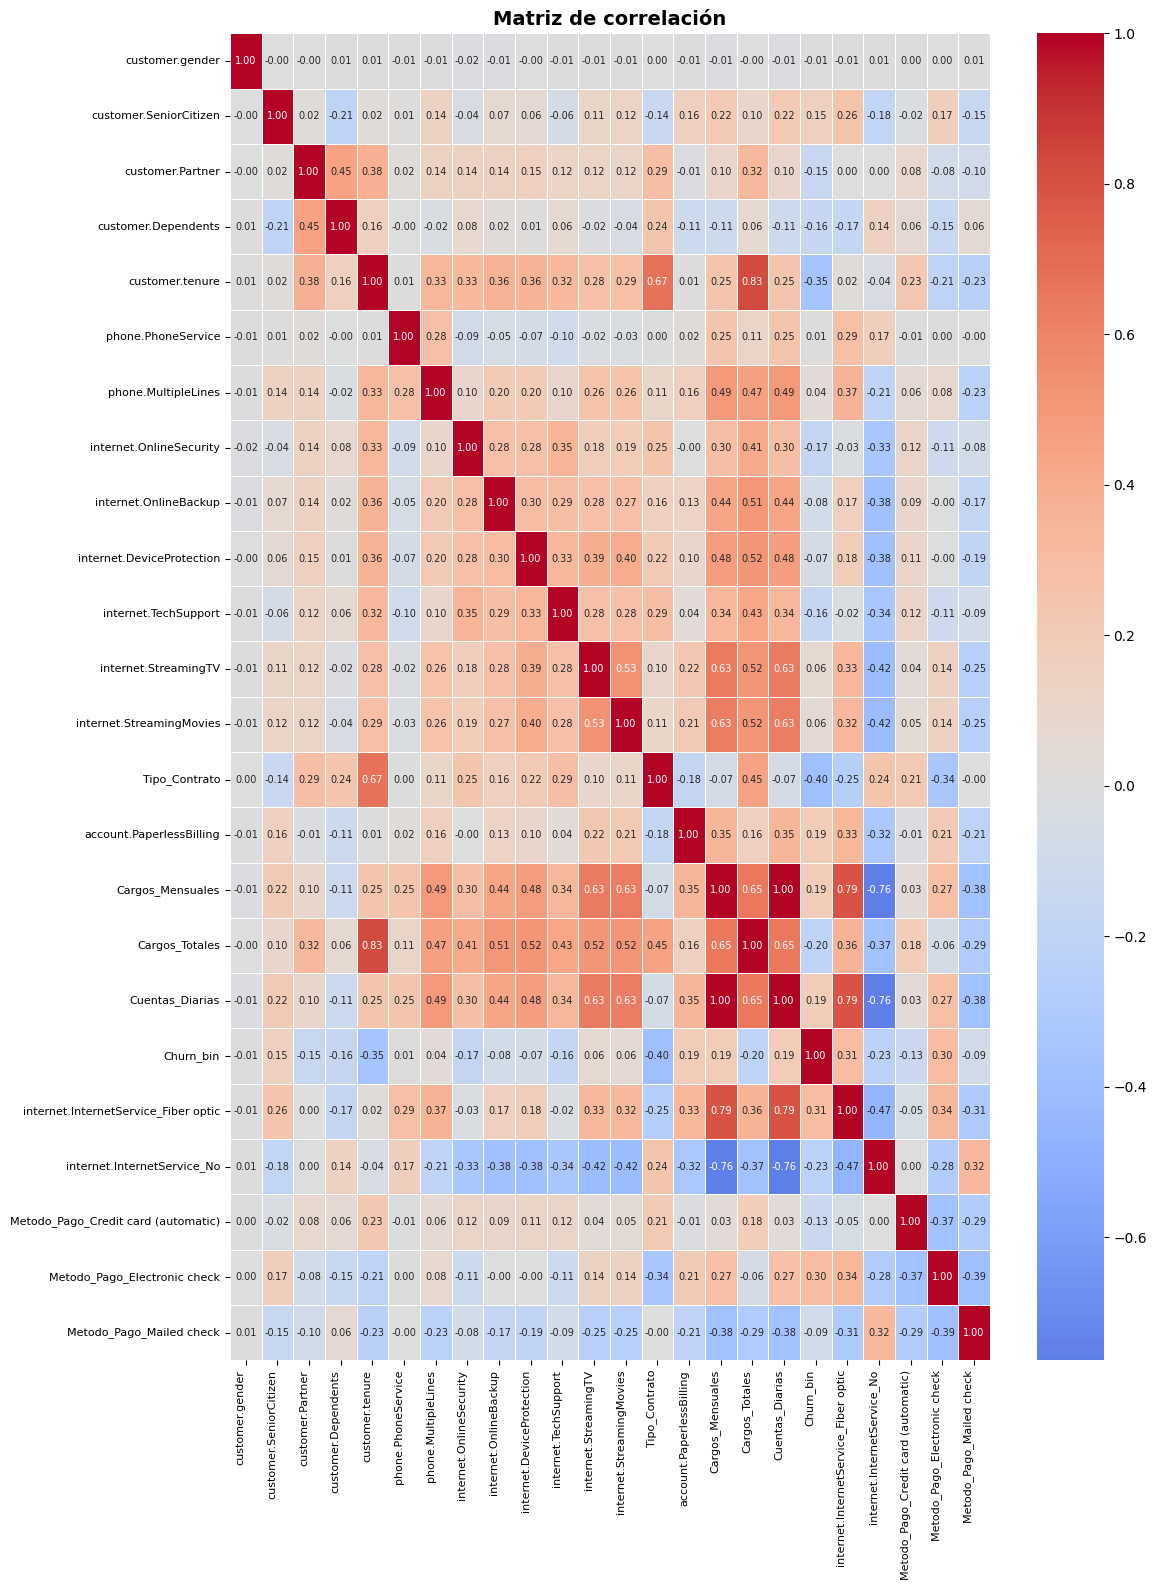

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

"""
Matriz de correlación de variables numéricas
"""
df_numericas = df_clean.select_dtypes(include = ["number"])
corr_matriz = df_numericas.corr()

"""
Visualización de la matriz de correlación
"""
plt.figure(figsize=(12,16))
sns.heatmap(
    corr_matriz,
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    center = 0, 
    linewidths = 0.5,
    annot_kws = {'size' : 7}
)

plt.title("Matriz de correlación", fontsize = 14, fontweight = "bold")
plt.xticks(rotation = 90, ha = "right", fontsize = 8)
plt.yticks(fontsize = 8)
plt.tight_layout()
plt.show()

=== Correlación con Churn_bin ===
Tipo_Contrato                          -0.397
customer.tenure                        -0.352
internet.InternetService_Fiber optic    0.308
Metodo_Pago_Electronic check            0.302
internet.InternetService_No            -0.228
Cargos_Totales                         -0.199
Cargos_Mensuales                        0.193
Cuentas_Diarias                         0.193
account.PaperlessBilling                0.192
internet.OnlineSecurity                -0.171
internet.TechSupport                   -0.165
customer.Dependents                    -0.164
customer.SeniorCitizen                  0.151
customer.Partner                       -0.150
Metodo_Pago_Credit card (automatic)    -0.134
Metodo_Pago_Mailed check               -0.092
internet.OnlineBackup                  -0.082
internet.DeviceProtection              -0.066
internet.StreamingTV                    0.063
internet.StreamingMovies                0.061
phone.MultipleLines                     0.040


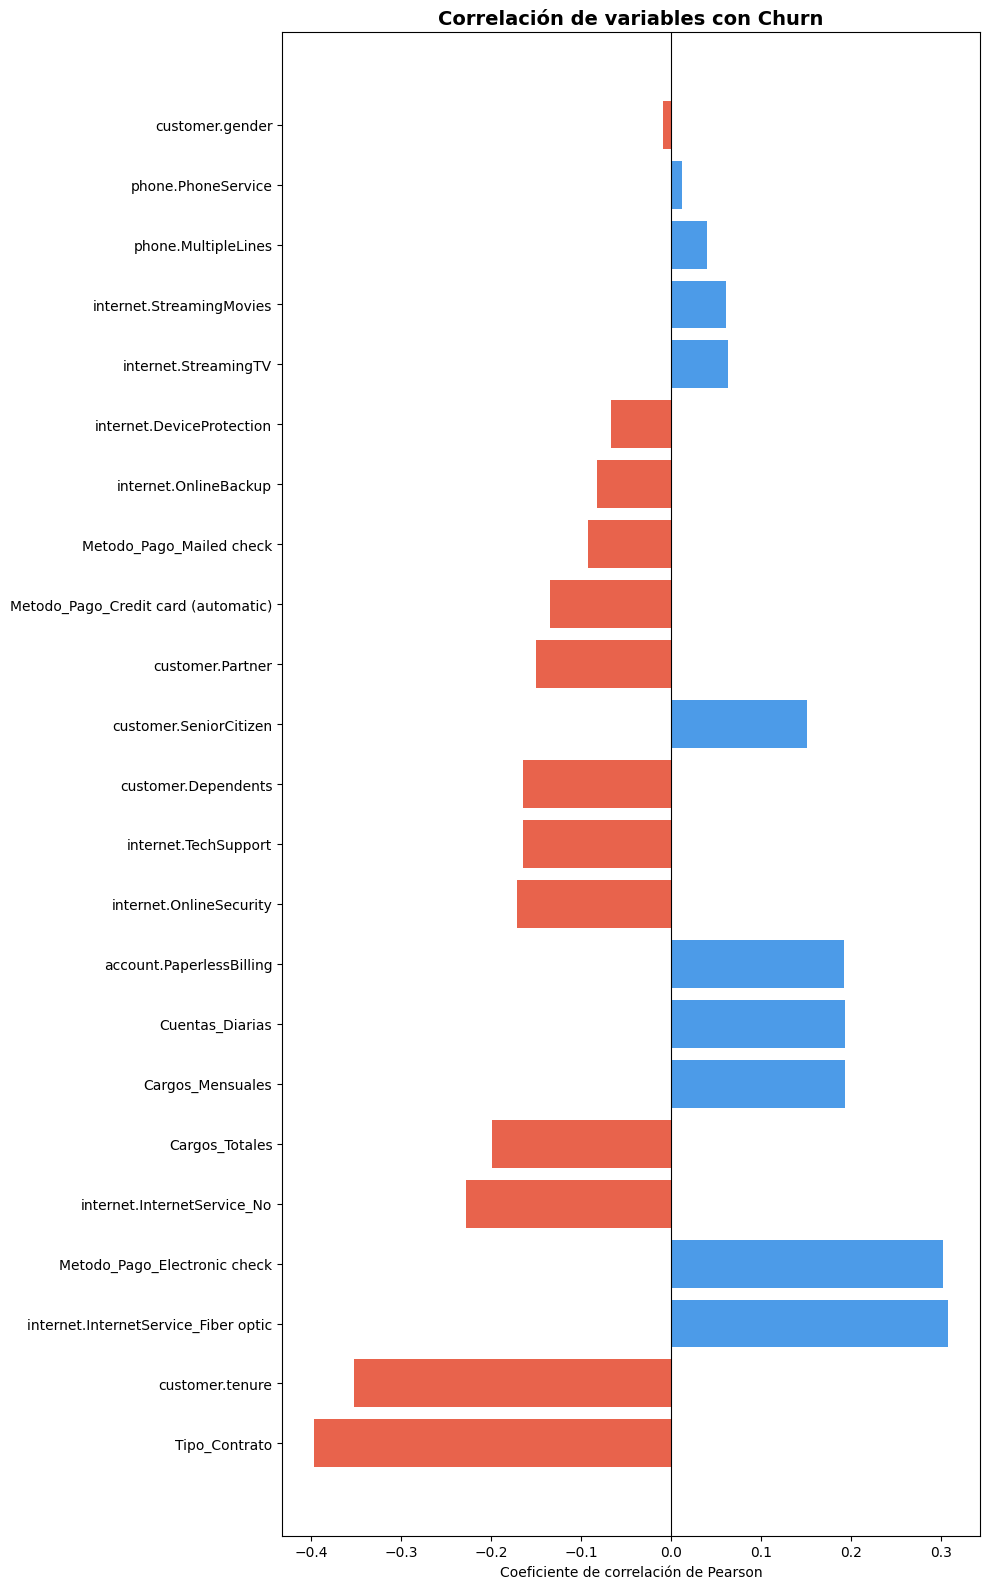

In [52]:
"""
Correlación específica con Churn_bin
"""
corr_churn = (
    corr_matriz["Churn_bin"].
    drop("Churn_bin")
    .sort_values(key = abs, ascending = False)
)

print("=== Correlación con Churn_bin ===")
print(corr_churn.round(3).to_string())

"""
Visualización: correlación con Churn_bin
"""
plt.figure(figsize=(10,16))
colors = ["#E8634C" if v < 0 else "#4C9BE8" for v in corr_churn.values]
plt.barh(corr_churn.index, corr_churn.values, color = colors)
plt.axvline(0, color = "black", linewidth = 0.8)
plt.title("Correlación de variables con Churn", fontsize = 14, fontweight = "bold")
plt.xlabel("Coeficiente de correlación de Pearson")
plt.tight_layout()
plt.show()

Las barras azules indican correlación positiva con el "Churn" y las naranjas correlación negativa. En ninguno de los casos se observa un valor de correlación mayor a 0.397 (correlación negativa con "Tipo_Contrato"). "customer.tenure" también presenta una de los mayores valores de correlación negativa (-0.352). En ambos casos se intuye que contratos más largos y una mayor antiguedad implican una mayor reticencia a la cancelación del contrato. En cuanto a la correlación positiva, el mayor valor se observa con "internet.InternetService_Fiber optic" (0.308) que podría indicar un mayor descontento con este servicio. 

## 2.2 Análisis dirigido

C:\Users\aaiza\AppData\Local\Temp\ipykernel_28132\1150921416.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\aaiza\AppData\Local\Temp\ipykernel_28132\1150921416.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\aaiza\AppData\Local\Temp\ipykernel_28132\1150921416.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


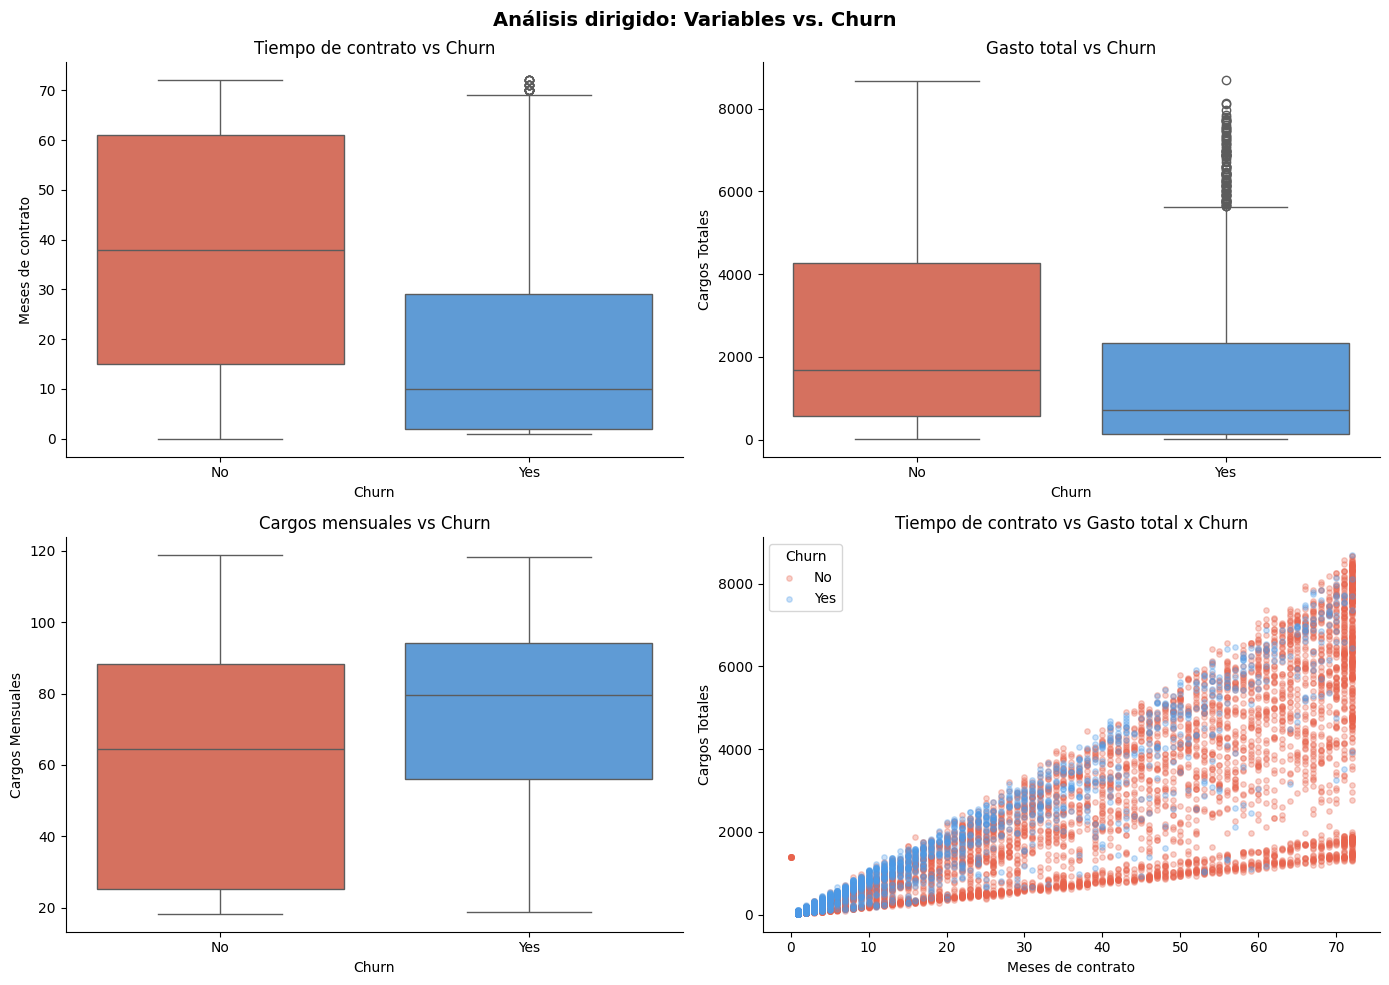

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2,2, figsize=(14,10))
fig.suptitle("Análisis dirigido: Variables vs. Churn", fontsize = 14, fontweight = "bold")

colors = {"Yes": "#4C9BE8", "No": "#E8634C"}

"""
Boxplot: Tiempo de contrato vs Churn
"""
sns.boxplot(
    data = df_clean, x = "Churn", y = "customer.tenure",
    palette = colors, ax = axs[0,0]
)

axs[0,0].set_title("Tiempo de contrato vs Churn")
axs[0,0].set_xlabel("Churn")
axs[0,0].set_ylabel("Meses de contrato")
axs[0,0].spines["top"].set_visible(False)
axs[0,0].spines["right"].set_visible(False)

"""
Boxplot: Gasto total vs Churn
"""
sns.boxplot(
    data =df_clean, x = "Churn", y = "Cargos_Totales",
    palette = colors, ax = axs[0,1]
)

axs[0,1].set_title("Gasto total vs Churn")
axs[0,1].set_xlabel("Churn")
axs[0,1].set_ylabel("Cargos Totales")
axs[0,1].spines["top"].set_visible(False)
axs[0,1].spines["right"].set_visible(False)

"""
Boxplot: Cargos mensuales vs Churn
"""
sns.boxplot(
    data = df_clean, x = "Churn", y = "Cargos_Mensuales",
    palette = colors, ax = axs[1,0]
)

axs[1,0].set_title("Cargos mensuales vs Churn")
axs[1,0].set_xlabel("Churn")
axs[1,0].set_ylabel("Cargos Mensuales")
axs[1,0].spines["top"].set_visible(False)
axs[1,0].spines["right"].set_visible(False)

"""
Scatter: Tiempo de contrato vs Gasto total x Churn
"""
for churn_val, group in df_clean.groupby("Churn"):
    axs[1,1].scatter(
        group["customer.tenure"],
        group["Cargos_Totales"],
        label = churn_val,
        alpha = 0.3,
        s = 15, 
        color = colors[churn_val]
    )

axs[1,1].set_title("Tiempo de contrato vs Gasto total x Churn")
axs[1,1].set_xlabel("Meses de contrato")
axs[1,1].set_ylabel("Cargos Totales")
axs[1,1].legend(title = "Churn")
axs[1,1].spines["top"].set_visible(False)
axs[1,1].spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

En el boxplot de "Tiempo de contrato vs Churn" se observa que los clientes que cancelaron se encuentran distribuidos, principalmente, entre los que tienen un menor tiempo de contrato.
En el boxplot de "Gasto total vs Churn" se observa que los clientes que cancelaron se encuentran distribuidos, principalmente, entre los que realizaron un gasto total menor.
En el boxplot de "Cargos mensuales vs Churn" se observa que los clientes que cancelaron se encuentran distribuidos, principalmente, entre los que tienen un mayor cargo mensual.
Finalmente, en el gráfico de "Tiempo de contrato vs Gasto total x Churn" se oberva que la menor proporción de cancelación se encuentra a mayor tiempo de contrato y mayores gastos totales. Entre los clientes más nuevos (menor cantidad de meses de contrato) y menores gastos totales, la tasa de cancelación es más alta.

# 3. Modelado predictivo

## 3.1. Separación de datos
Se divide el conjunto de datos en entrenamiento y prueba para evaluar el rendimiento del modelo. Se usará una división de 70% para entrenamiento y 30% para prueba. 

In [54]:
from sklearn.model_selection import train_test_split

"""
Definición de features y variable objetivo
"""
X = df_clean.drop(columns = ["Churn", "Churn_bin"])
y = df_clean["Churn_bin"]

"""
División de datos en entrenamiento y prueba
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

"""
Verificación
"""
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"\nProporción de Churn en y_train:\n{y_train.value_counts(normalize=True).round(3)}")
print(f"\nProporción de Churn en y_test:\n{y_test.value_counts(normalize=True).round(3)}")

X_train: (4930, 23)
X_test: (2113, 23)

Proporción de Churn en y_train:
Churn_bin
0    0.735
1    0.265
Name: proportion, dtype: float64

Proporción de Churn en y_test:
Churn_bin
0    0.735
1    0.265
Name: proportion, dtype: float64


## 3.2. Creación de modelos


### 3.2.1. Regresión logística

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

"""
Definición de modelo
"""
pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  LogisticRegression(random_state=42, max_iter=1000))
])

"""
Entrenamiento del modelo
"""
pipeline_lr.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not wo

### 3.2.2. Decision Tree

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

"""
Definición de modelo
"""
pipeline_dt = Pipeline([
    ("model",  DecisionTreeClassifier(random_state=42))
])

"""
Entrenamiento del modelo
"""
pipeline_dt.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If f

### 3.2.3. Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


"""
Definición de modelo
"""
pipeline_rf = Pipeline([
    ("model",  RandomForestClassifier(random_state=42))
])

"""
Entrenamiento del modelo
"""
pipeline_rf.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If 

### 3.2.4. XGBoost

In [58]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline


"""
Definición de modelo
"""
pipeline_xg = Pipeline([
    ("model",  XGBClassifier(random_state=42, eval_metric = "logloss"))
])

"""
Entrenamiento del modelo
"""
pipeline_xg.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,None


## 3.3. Evaluación de modelos
Se evalúa cada modelo utilizando los siguientes parámetros: "exactitud", "precisión", "recall", "F1-score", "matriz de confusión". 

=== Comparación de modelos ===
                     Exactitud (test)  Exactitud (train)  Precisión  Recall  F1-Score
Modelo                                                                               
Regresión logística             0.798              0.811      0.642   0.545     0.590
Decision Tree                   0.735              0.998      0.500   0.517     0.508
Random Forest                   0.788              0.998      0.624   0.508     0.560
XGBoost                         0.781              0.940      0.596   0.544     0.568


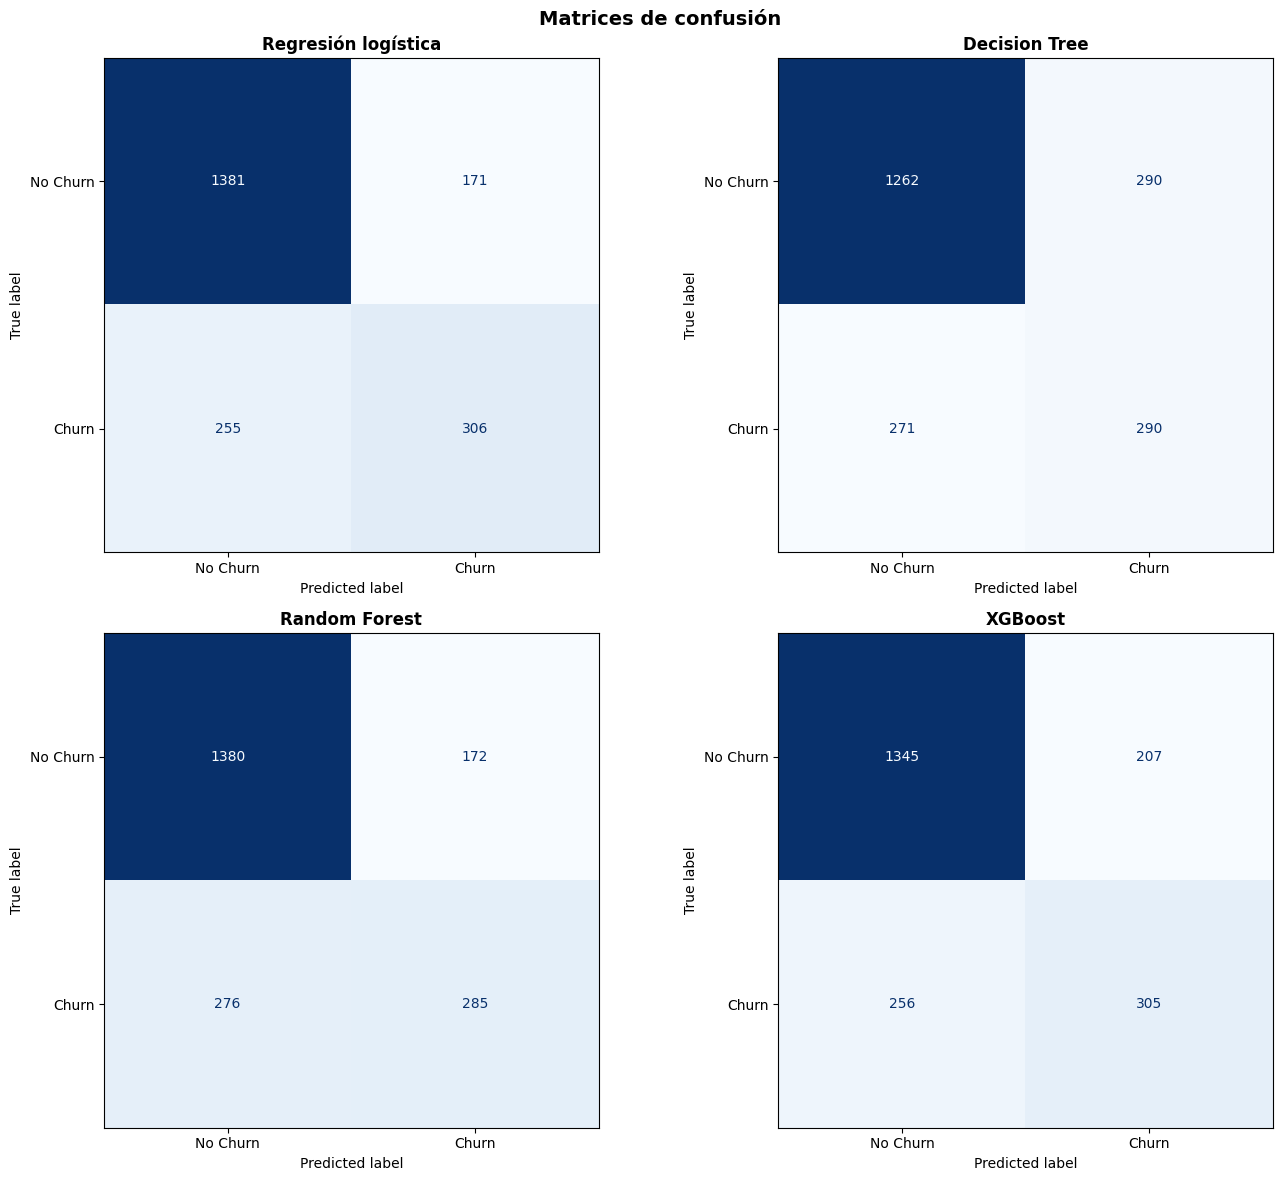

In [60]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix, 
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import pandas as pd

"""
Definición de modelos a evaluar
"""
pipelines = {
    "Regresión logística": pipeline_lr,
    "Decision Tree": pipeline_dt,
    "Random Forest": pipeline_rf, 
    "XGBoost": pipeline_xg
}

"""
Cálculo de métricas
"""
resultados = []

for nombre, pipeline in pipelines.items():
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)
    
    resultados.append({
        "Modelo":             nombre,
        "Exactitud (test)":   round(accuracy_score(y_test,  y_pred), 3),
        "Exactitud (train)":  round(accuracy_score(y_train, y_pred_train), 3),
        "Precisión":          round(precision_score(y_test, y_pred), 3),
        "Recall":             round(recall_score(y_test,    y_pred), 3),
        "F1-Score":           round(f1_score(y_test,        y_pred), 3),
    })
    
df_resultados = pd.DataFrame(resultados).set_index("Modelo")
print("=== Comparación de modelos ===")
print(df_resultados.to_string())

"""
Matrices de confusión
"""
fig, axs = plt.subplots(2,2, figsize=(14,12))
fig.suptitle("Matrices de confusión", fontsize = 14, fontweight = "bold")

for ax, (nombre, pipeline) in zip(axs.flatten(), pipelines.items()):
    y_pred = pipeline.predict(X_test)
    ConfusionMatrixDisplay(
        confusion_matrix(y_test, y_pred),
        display_labels = ["No Churn", "Churn"]
    ).plot(ax=ax, colorbar = False, cmap = "Blues")
    ax.set_title(nombre, fontweight = "bold")
    
plt.tight_layout()
plt.show()

El modelo de **Regresión logística** tuvo un F1-Score más alto (0.590), la mejor precisión (0.642) y el mejor recall (0.545), por ende es el modelo que presentó un mejor desempeño. Además, no presenta overfitting, pues su train y test son básicamente iguales. 

Así mismo, se oberva que **Decision Tree** presenta un overfitting severo (diferencia entre train y test es de casi 26 puntos). Una exactitud de 99.8% en entrenamiento significa que el modelo memorizó practicamente cada registro del dataset en lugar de aprender patrones generalizables. 

El modelo **Random forest** presenta un overfitting moderado (diferencia entre train y test de casi 21 puntos).

El modelo **XGBoost** presenta un overfitting leve (diferencia entre train y test de casi 16 puntos). 

# 4. Interpretación y conclusiones


## 4.1. Análisis de la importancia de las variables


=== Importancia de variables — Regresión Logística ===
                            Variable  Coeficiente
                     customer.tenure    -1.463382
                      Cargos_Totales     0.711358
internet.InternetService_Fiber optic     0.582115
                       Tipo_Contrato    -0.577991
         internet.InternetService_No    -0.505888
                     Cuentas_Diarias    -0.271788
                    Cargos_Mensuales    -0.271606
            account.PaperlessBilling     0.202457
                internet.StreamingTV     0.178955
        Metodo_Pago_Electronic check     0.173539
                 phone.MultipleLines     0.169885
            internet.StreamingMovies     0.159310
                internet.TechSupport    -0.153377
             internet.OnlineSecurity    -0.101367
                 customer.Dependents    -0.094748
                  phone.PhoneService    -0.070282
              customer.SeniorCitizen     0.062172
                     customer.gender    -0.04

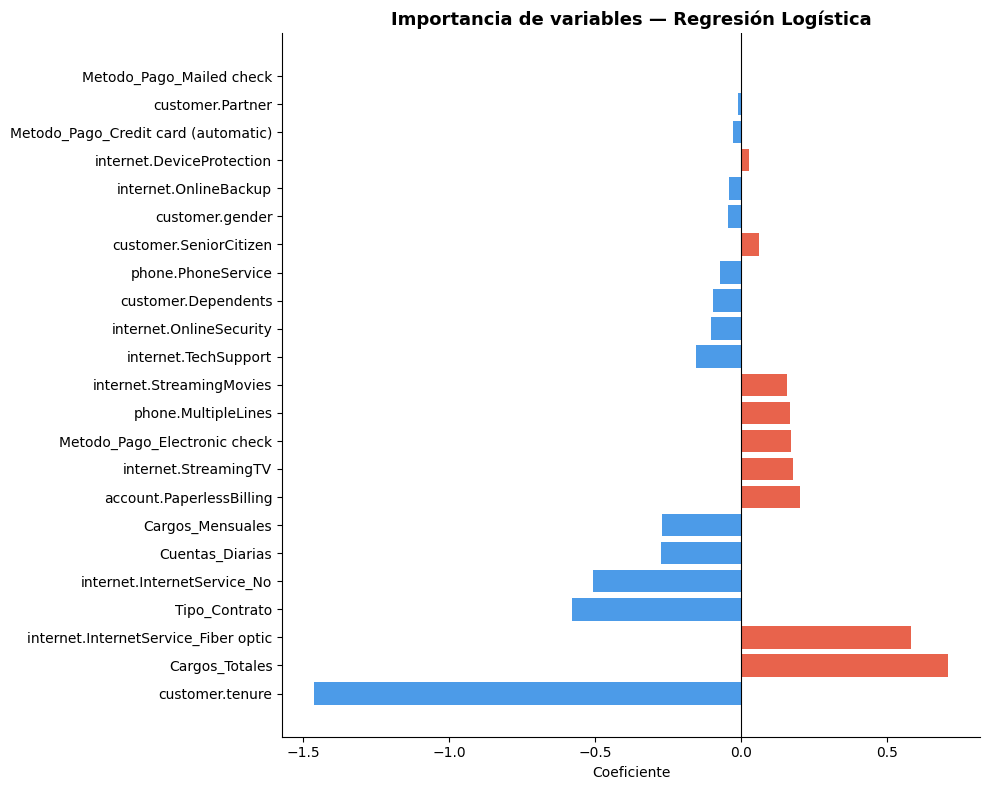

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

"""
Extracción de coeficientes
"""
feature_names = X_train.columns.tolist()
coeficientes  = pipeline_lr.named_steps["model"].coef_[0]

df_coef = pd.DataFrame({
    "Variable":     feature_names,
    "Coeficiente":  coeficientes
}).sort_values("Coeficiente", key=abs, ascending=False)

print("=== Importancia de variables — Regresión Logística ===")
print(df_coef.to_string(index=False))

"""
Visualización
"""
plt.figure(figsize=(10, 8))
colors = ["#E8634C" if c > 0 else "#4C9BE8" for c in df_coef["Coeficiente"]]

plt.barh(df_coef["Variable"], df_coef["Coeficiente"], color=colors)
plt.axvline(0, color="black", linewidth=0.8)
plt.title("Importancia de variables — Regresión Logística", fontsize=13, fontweight="bold")
plt.xlabel("Coeficiente")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

Las barras naranja representan a las variables que aumentan la probabilidad de "Churn" y las azules las reducen. En general, se puede observar que variables como "Tipo_Contrato" y "customer.tenure" tienen coeficientes negativos altos: una mayor antiguedad y contratos más extensos reducen el "Churn". En cuanto a variables como "interne.InternetService_Fiber optic" presenta el mayor coeficiente positivo, lo que indica que clientes con fibra óptica tienen mayor probabilidad de cancelar. 

## 4.2. Conclusión
- Se entrenaron y evaluaron 4 modelos de clasificación. La métrica principal de comparación fue el "F1-Score", siendo seleccionado la "**Regresión logística**" como modelo final al ser el único que no presenta *overfitting*. 
- En base al matriz de confusión, se observa que el modelo de "**Regresión logística**" clasificó correctamente 1 381 clientes activos y 306 clientes que cancelaron. Sin embargo, no detectó 255 cancelaciones reales (falsos negativos) y clasificó 171 clientes como cancelaciones cuando aún estaban activos (falsos positivos). 
- Los factores que más aumentan el riesgo de cancelación son "Cargos_Totales" con un coeficiente de "+0.711", "internet.InternetService_Fiber optics" con un coeficiente de "+0.582" y "account.PaperlessBilling" con "+0.202".
- Los factores que reducen el riesgo de cancelación son "customer.tenure" con un coeficiente de "-1.463", "Tipo_contrato" con "-0.578" e "internet.InternetService_No" con "-0.506.